In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
import hypergrad as hg
import numpy as np
import torch.nn.functional as F
#from sklearn.datasets import make_spd_matrix as spd
import time

In [2]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyper-representation with two-layers net 

In [3]:
p, q, d, n = 256, 512, 256, 5000 # CG was not working with n=10000 
m = 0.1 

Xg = torch.randn((n, p)) # data 
H1_true = torch.randn((p, q)) # layer 1
H2_true = torch.randn((q, d)) # layer 2
w_true = torch.randn(d) # final regression layer

yg = F.sigmoid(F.sigmoid(Xg @ H1_true) @ H2_true) @ w_true + m * torch.randn(n)
Xf = torch.randn((n, p))
yf = F.sigmoid(F.sigmoid(Xf @ H1_true) @ H2_true) @ w_true + m * torch.randn(n)

/Users/bookAir/anaconda3/envs/cv/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [4]:
b = 0.001

def hypernet(hparams, X): 
    H1 = hparams[0]
    H2 = hparams[1]
    out = F.sigmoid(F.sigmoid(X @ H1) @ H2) 
    
    return out

def regressor(params, Z, y):
    w = params[0]
    loss = (torch.norm(Z @ w - y))**2
    
    return loss
    
def inner_func(params, hparams):
    w = params[0]
    #sigmoid
    Zg = hypernet(hparams, Xg)
    lg = regressor(params, Zg, yg)
    g = 0.5 * lg / n + 0.5 * b * (torch.norm(w))**2
   
    return g #.squeeze()

def outer_func(params, hparams):
    w = params[0]
    #sigmoid
    Zf = hypernet(hparams, Xf)
    lf = regressor(params, Zf, yf)
    f = 0.5 * lf / n
    
    return f #.squeeze()

###########################################################
alpha = .001
p0 = [torch.randn(d)]
hp0 = [torch.randn((p, q)), torch.randn((q, d))]

def map_func(params, hparams):
    
    g = inner_func(params, hparams)
    inner_losses.append(g.item())
    #print(torch.norm(torch.autograd.grad(g, params, create_graph=True)[0]))
    
    return [params[0] - alpha * torch.autograd.grad(g, params, create_graph=True)[0]]

def inner_solver(hparams, steps=20, params0=None, optim=None):

    # params = [torch.randn(d).requires_grad_(True)]
    params = [p.requires_grad_(True) for p in p0]

    Zg = hypernet(hparams, Xg)
    for _ in range(steps):
        loss = 0.5 * regressor(params, Zg, yg) / n + 0.5 * b * (torch.norm(params[0]))**2
        params = [params[0] - alpha * torch.autograd.grad(loss, params, create_graph=True)[0]]

    return params


/Users/bookAir/anaconda3/envs/cv/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


outer step=0 (4.98e-01s)(1.26e-01, 3.71e-01) | val loss=30.493314743041992 | hypergrad norm = 5.132e+00
outer step=10 (4.49e-01s)(8.95e-02, 3.59e-01) | val loss=13.894075393676758 | hypergrad norm = 2.575e+00
outer step=20 (4.56e-01s)(8.97e-02, 3.65e-01) | val loss=4.814870357513428 | hypergrad norm = 1.118e+00
outer step=30 (4.54e-01s)(9.00e-02, 3.63e-01) | val loss=1.8685228824615479 | hypergrad norm = 5.534e-01
outer step=40 (4.50e-01s)(8.96e-02, 3.60e-01) | val loss=0.7942010164260864 | hypergrad norm = 3.530e-01
outer step=50 (4.51e-01s)(8.96e-02, 3.61e-01) | val loss=0.3077293932437897 | hypergrad norm = 2.120e-01
outer step=60 (4.54e-01s)(9.02e-02, 3.63e-01) | val loss=0.13997264206409454 | hypergrad norm = 1.388e-01
outer step=70 (4.53e-01s)(9.01e-02, 3.62e-01) | val loss=0.06603782624006271 | hypergrad norm = 9.673e-02
outer step=80 (4.67e-01s)(9.48e-02, 3.71e-01) | val loss=0.052640050649642944 | hypergrad norm = 9.832e-02
outer step=90 (4.55e-01s)(9.04e-02, 3.64e-01) | val l

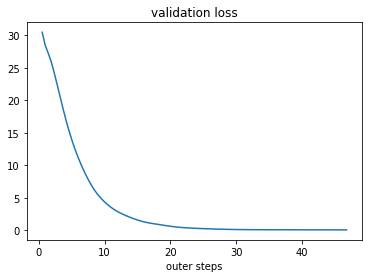

In [5]:
# AID-CG method

K = 100
eval_interval = 10
T = 30 # did not work with 10
beta = 0.01

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time, hg_norms = 0,  [], [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.CG(params, hparams, T, map_func, outer_func, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)
    hg_norms.append(torch.norm(hparams[0].grad))

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))


print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
plt.plot(running_time, val_losses)
#plt.savefig('plots/val_loss2.png', bbox_inches='tight')
#plt.close()
plt.show()
norm_cg = hg_norms
val_cg = val_losses
run_cg = running_time



/Users/bookAir/anaconda3/envs/cv/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


outer step=0 (3.72e-01s)(1.12e-01, 2.58e-01) | val loss=37.435218811035156 | hypergrad norm = 3.016e+00
outer step=10 (3.17e-01s)(7.38e-02, 2.42e-01) | val loss=4.190643787384033 | hypergrad norm = 6.735e-01
outer step=20 (3.19e-01s)(7.49e-02, 2.43e-01) | val loss=0.6477265357971191 | hypergrad norm = 2.246e-01
outer step=30 (3.16e-01s)(7.44e-02, 2.40e-01) | val loss=0.22960969805717468 | hypergrad norm = 1.578e-01
outer step=40 (3.20e-01s)(7.44e-02, 2.44e-01) | val loss=0.07657165825366974 | hypergrad norm = 9.058e-02
outer step=50 (3.16e-01s)(7.46e-02, 2.41e-01) | val loss=0.022007040679454803 | hypergrad norm = 4.228e-02
outer step=60 (3.19e-01s)(7.38e-02, 2.44e-01) | val loss=0.007290894165635109 | hypergrad norm = 2.243e-02
outer step=70 (3.16e-01s)(7.50e-02, 2.40e-01) | val loss=0.0029925592243671417 | hypergrad norm = 1.378e-02
outer step=80 (3.21e-01s)(7.44e-02, 2.45e-01) | val loss=0.0013060560449957848 | hypergrad norm = 8.324e-03
outer step=90 (3.19e-01s)(7.42e-02, 2.44e-01)

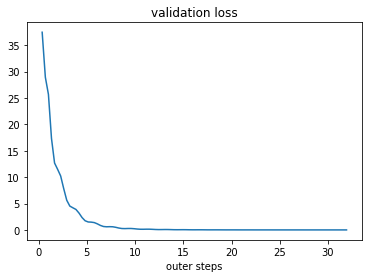

In [11]:
# ESJ method
K = 100
eval_interval = 10
T = 10
mu = .1
beta = .01

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time, hg_norms = 0,  [], [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hgvesj(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)
    hg_norms.append(torch.norm(hparams[0].grad))

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
plt.plot(running_time, val_losses)
plt.show()

norm_zoj = hg_norms
val_zoj = val_losses
run_zoj = running_time


/Users/bookAir/anaconda3/envs/cv/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


outer step=0 (4.55e-01s)(1.01e-01, 3.52e-01) | val loss=37.435218811035156 | hypergrad norm = 3.075e+00
outer step=10 (4.31e-01s)(7.72e-02, 3.52e-01) | val loss=3.508333683013916 | hypergrad norm = 6.299e-01
outer step=20 (4.31e-01s)(7.97e-02, 3.51e-01) | val loss=0.5191173553466797 | hypergrad norm = 2.118e-01
outer step=30 (4.19e-01s)(7.65e-02, 3.42e-01) | val loss=0.18181048333644867 | hypergrad norm = 1.496e-01
outer step=40 (4.27e-01s)(7.56e-02, 3.51e-01) | val loss=0.054309528321027756 | hypergrad norm = 8.001e-02
outer step=50 (4.23e-01s)(7.99e-02, 3.42e-01) | val loss=0.01580842211842537 | hypergrad norm = 3.895e-02
outer step=60 (4.15e-01s)(7.47e-02, 3.39e-01) | val loss=0.006608482450246811 | hypergrad norm = 2.746e-02
outer step=70 (4.14e-01s)(7.45e-02, 3.39e-01) | val loss=0.0026582321152091026 | hypergrad norm = 1.820e-02
outer step=80 (4.15e-01s)(7.47e-02, 3.39e-01) | val loss=0.0010267894249409437 | hypergrad norm = 1.117e-02
outer step=90 (4.16e-01s)(7.49e-02, 3.40e-01)

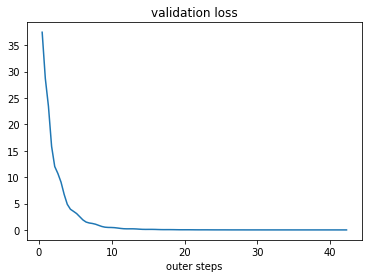

In [8]:
# AID-FP method 

K = 100
eval_interval = 10
T = 10
beta = 0.01 

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time, hg_norms = 0,  [], [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.fixed_point(params, hparams, T, map_func, outer_func, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)
    hg_norms.append(torch.norm(hparams[0].grad))

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
plt.plot(running_time, val_losses)
#plt.savefig('plots/val_loss2.png', bbox_inches='tight')
#plt.close()
plt.show()

norm_fp = hg_norms
val_fp = val_losses
run_fp = running_time
    

/Users/bookAir/anaconda3/envs/cv/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


outer step=0 (3.15e-01s)(1.02e-01, 2.12e-01) | val loss=37.435218811035156 | hypergrad norm = 3.815e-03
outer step=10 (3.61e-01s)(7.81e-02, 2.47e-01) | val loss=34.33385467529297 | hypergrad norm = 2.014e-02
outer step=20 (3.09e-01s)(7.75e-02, 2.30e-01) | val loss=31.26731300354004 | hypergrad norm = 1.568e-02
outer step=30 (3.02e-01s)(8.00e-02, 2.21e-01) | val loss=29.16305923461914 | hypergrad norm = 2.308e-03
outer step=40 (3.10e-01s)(8.19e-02, 2.27e-01) | val loss=28.510372161865234 | hypergrad norm = 2.880e-03
outer step=50 (3.02e-01s)(7.97e-02, 2.22e-01) | val loss=28.05843162536621 | hypergrad norm = 9.441e-03
outer step=60 (3.03e-01s)(7.78e-02, 2.24e-01) | val loss=27.393444061279297 | hypergrad norm = 1.583e-03
outer step=70 (2.95e-01s)(7.65e-02, 2.17e-01) | val loss=27.647981643676758 | hypergrad norm = 2.937e-03
outer step=80 (3.02e-01s)(7.89e-02, 2.19e-01) | val loss=27.011615753173828 | hypergrad norm = 1.907e-03
outer step=90 (2.97e-01s)(7.67e-02, 2.19e-01) | val loss=27.

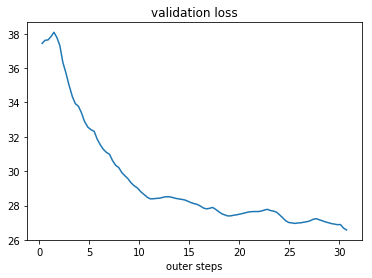

In [9]:
# HOZOG method 
K = 100
eval_interval = 10
T = 10
mu = 0.1
beta = .2

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time, hg_norms = 0,  [], [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hozog(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, params0=None, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)
    hg_norms.append(torch.norm(hparams[0].grad))

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        #print('suboptimality (H - H*) = {:.3e} | suboptimality (w - w*) = {:.3e} | hypergrad norm = {:.3e}'.format(torch.norm(hparams[0] - H_true, 'fro'), torch.norm(params[0] - w_true), torch.norm(hparams[0].grad)))



print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
plt.plot(running_time, val_losses)
#plt.savefig('plots/val_loss2.png', bbox_inches='tight')
#plt.close()
plt.show()

norm_hozog = hg_norms
val_hozog = val_losses
run_hozog = running_time

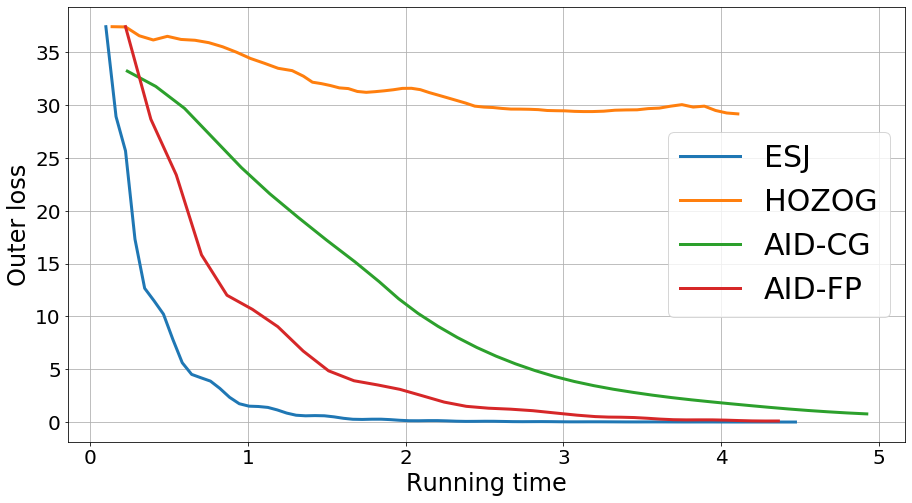

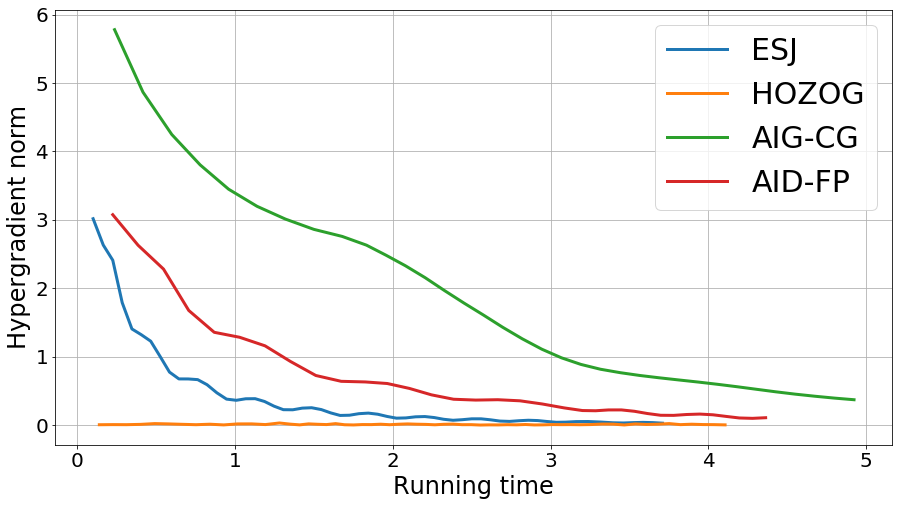

In [78]:
# range to plot 
s1 = 35
s2 = 60
s3 = 35

# s1 = 100
# s2 = 100
# s3 = 100

lw = 3
iters = list(range(K))
plt.plot(run_zoj[:s2+12], val_zoj[:s2+12], '-', label='ESJ', linewidth=lw)
plt.plot(run_hozog[:s2], val_hozog[:s2], '-', label='HOZOG', linewidth=lw)
plt.plot(run_cg[:s1], val_cg[:s1], '-', label='AID-CG', linewidth=lw)
plt.plot(run_fp[:s3], val_fp[:s3], '-', label='AID-FP', linewidth=lw)
plt.xlabel('Running time', fontsize=24)
plt.ylabel('Outer loss', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='center right', fontsize=30)
plt.grid()
plt.gcf().set_size_inches(15, 8)
plt.show()

plt.plot(run_zoj[:s2], norm_zoj[:s2], '-', label='ESJ', linewidth=lw)
plt.plot(run_hozog[:s2], norm_hozog[:s2], '-', label='HOZOG', linewidth=lw)
plt.plot(run_cg[:s1], norm_cg[:s1], '-', label='AIG-CG', linewidth=lw)
plt.plot(run_fp[:s3], norm_fp[:s3], '-', label='AID-FP', linewidth=lw)

plt.xlabel('Running time', fontsize=24)
plt.ylabel('Hypergradient norm', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize=30) #'lower right'
plt.grid()
plt.gcf().set_size_inches(15, 8)
plt.show()

# Different number T of inner loop steps 

In [13]:
p, q, d, n = 256, 512, 256, 5000 
m = 0.1 

Xg = torch.randn((n, p)) # data 
H1_true = torch.randn((p, q)) # layer 1
H2_true = torch.randn((q, d)) # layer 2
w_true = torch.randn(d) # final regression layer

yg = F.sigmoid(F.sigmoid(Xg @ H1_true) @ H2_true) @ w_true + m * torch.randn(n)
Xf = torch.randn((n, p))
yf = F.sigmoid(F.sigmoid(Xf @ H1_true) @ H2_true) @ w_true + m * torch.randn(n)

/Users/bookAir/anaconda3/envs/cv/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [14]:
b = 0.001

def hypernet(hparams, X): 
    H1 = hparams[0]
    H2 = hparams[1]
    out = F.sigmoid(F.sigmoid(X @ H1) @ H2) 
    
    return out

def regressor(params, Z, y):
    w = params[0]
    loss = (torch.norm(Z @ w - y))**2
    
    return loss
    
def inner_func(params, hparams):
    w = params[0]
    #sigmoid
    Zg = hypernet(hparams, Xg)
    lg = regressor(params, Zg, yg)
    g = 0.5 * lg / n + 0.5 * b * (torch.norm(w))**2
   
    return g #.squeeze()

def outer_func(params, hparams):
    w = params[0]
    #sigmoid
    Zf = hypernet(hparams, Xf)
    lf = regressor(params, Zf, yf)
    f = 0.5 * lf / n
    
    return f #.squeeze()

###########################################################
alpha = .0003
p0 = [torch.randn(d)]
hp0 = [torch.randn((p, q)), torch.randn((q, d))]

def map_func(params, hparams):
    
    g = inner_func(params, hparams)
    inner_losses.append(g.item())
    #print(torch.norm(torch.autograd.grad(g, params, create_graph=True)[0]))
    
    return [params[0] - alpha * torch.autograd.grad(g, params, create_graph=True)[0]]

def inner_solver(hparams, steps=100, params0=None, optim=None):

    # params = [torch.randn(d).requires_grad_(True)]
    params = [p.requires_grad_(True) for p in p0]

    Zg = hypernet(hparams, Xg)
    for _ in range(steps):
        loss = 0.5 * regressor(params, Zg, yg) / n + 0.5 * b * (torch.norm(params[0]))**2
        params = [params[0] - alpha * torch.autograd.grad(loss, params, create_graph=True)[0]]

    return params



T = 5

/Users/bookAir/anaconda3/envs/cv/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


outer step=0 (3.47e-01s)(1.05e-01, 2.40e-01) | val loss=46.34346008300781 | hypergrad norm = 3.333e+00
outer step=10 (3.07e-01s)(6.99e-02, 2.36e-01) | val loss=5.652091979980469 | hypergrad norm = 8.122e-01
outer step=20 (3.06e-01s)(6.99e-02, 2.36e-01) | val loss=0.8814826011657715 | hypergrad norm = 2.508e-01
outer step=30 (3.07e-01s)(7.04e-02, 2.36e-01) | val loss=0.409040242433548 | hypergrad norm = 2.039e-01
outer step=40 (3.07e-01s)(7.00e-02, 2.36e-01) | val loss=0.15993773937225342 | hypergrad norm = 1.304e-01
outer step=50 (3.09e-01s)(7.11e-02, 2.37e-01) | val loss=0.0448027178645134 | hypergrad norm = 6.092e-02
outer step=60 (3.09e-01s)(7.04e-02, 2.38e-01) | val loss=0.014876265078783035 | hypergrad norm = 2.892e-02
outer step=70 (3.09e-01s)(7.07e-02, 2.37e-01) | val loss=0.006633054465055466 | hypergrad norm = 1.675e-02
outer step=80 (3.10e-01s)(7.04e-02, 2.39e-01) | val loss=0.0031318531837314367 | hypergrad norm = 1.103e-02
outer step=90 (3.12e-01s)(7.06e-02, 2.40e-01) | val

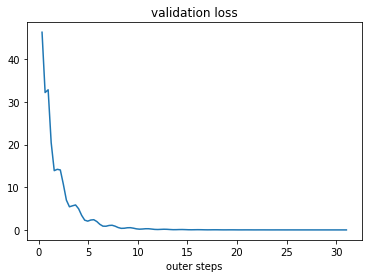

In [5]:
K = 100
eval_interval = 10
T = 5
mu = .1
beta = .01

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time, hg_norms = 0,  [], [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hgvesj(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)
    hg_norms.append(torch.norm(hparams[0].grad))

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
plt.plot(running_time, val_losses)
#plt.savefig('plots/val_loss2.png', bbox_inches='tight')
#plt.close()
plt.show()

norm_zoj5 = hg_norms
val_zoj5 = val_losses
run_zoj5 = running_time



T = 10

/Users/bookAir/anaconda3/envs/cv/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


outer step=0 (3.50e-01s)(1.06e-01, 2.42e-01) | val loss=37.435218811035156 | hypergrad norm = 3.016e+00
outer step=10 (3.17e-01s)(7.46e-02, 2.42e-01) | val loss=4.187587738037109 | hypergrad norm = 6.733e-01
outer step=20 (3.18e-01s)(7.45e-02, 2.42e-01) | val loss=0.6485164165496826 | hypergrad norm = 2.246e-01
outer step=30 (3.18e-01s)(7.47e-02, 2.42e-01) | val loss=0.23038049042224884 | hypergrad norm = 1.579e-01
outer step=40 (3.21e-01s)(7.53e-02, 2.44e-01) | val loss=0.07708700001239777 | hypergrad norm = 9.077e-02
outer step=50 (3.19e-01s)(7.48e-02, 2.43e-01) | val loss=0.022075597196817398 | hypergrad norm = 4.244e-02
outer step=60 (3.19e-01s)(7.44e-02, 2.44e-01) | val loss=0.0073136016726493835 | hypergrad norm = 2.248e-02
outer step=70 (3.19e-01s)(7.47e-02, 2.44e-01) | val loss=0.0029676028061658144 | hypergrad norm = 1.370e-02
outer step=80 (3.22e-01s)(7.47e-02, 2.46e-01) | val loss=0.0012657700572162867 | hypergrad norm = 8.370e-03
outer step=90 (3.29e-01s)(7.54e-02, 2.53e-01

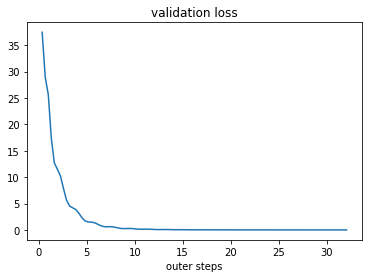

In [6]:
K = 100
eval_interval = 10
T = 10
mu = .1
beta = .01

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time, hg_norms = 0,  [], [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hgvesj(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)
    hg_norms.append(torch.norm(hparams[0].grad))

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
plt.plot(running_time, val_losses)
#plt.savefig('plots/val_loss2.png', bbox_inches='tight')
#plt.close()
plt.show()

norm_zoj10 = hg_norms
val_zoj10 = val_losses
run_zoj10 = running_time



T = 20

/Users/bookAir/anaconda3/envs/cv/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


outer step=0 (4.23e-01s)(1.65e-01, 2.57e-01) | val loss=31.710590362548828 | hypergrad norm = 2.789e+00
outer step=10 (3.33e-01s)(8.30e-02, 2.49e-01) | val loss=2.946906805038452 | hypergrad norm = 5.549e-01
outer step=20 (3.36e-01s)(8.47e-02, 2.50e-01) | val loss=0.4375735819339752 | hypergrad norm = 1.996e-01
outer step=30 (3.37e-01s)(8.42e-02, 2.52e-01) | val loss=0.12945161759853363 | hypergrad norm = 1.202e-01
outer step=40 (3.37e-01s)(8.24e-02, 2.54e-01) | val loss=0.03934400528669357 | hypergrad norm = 6.374e-02
outer step=50 (3.35e-01s)(8.27e-02, 2.52e-01) | val loss=0.018117085099220276 | hypergrad norm = 4.557e-02
outer step=60 (3.38e-01s)(8.38e-02, 2.53e-01) | val loss=0.005917677190154791 | hypergrad norm = 2.527e-02
outer step=70 (3.44e-01s)(8.37e-02, 2.59e-01) | val loss=0.0022658391389995813 | hypergrad norm = 1.561e-02
outer step=80 (3.38e-01s)(8.37e-02, 2.53e-01) | val loss=0.0012254954781383276 | hypergrad norm = 1.269e-02
outer step=90 (3.43e-01s)(8.50e-02, 2.57e-01)

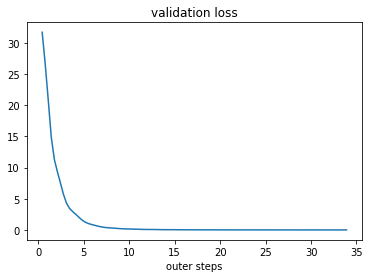

In [7]:
K = 100
eval_interval = 10
T = 20
mu = .1
beta = .01

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time, hg_norms = 0,  [], [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hgvesj(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)
    hg_norms.append(torch.norm(hparams[0].grad))

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
plt.plot(running_time, val_losses)
#plt.savefig('plots/val_loss2.png', bbox_inches='tight')
#plt.close()
plt.show()

norm_zoj20 = hg_norms
val_zoj20 = val_losses
run_zoj20 = running_time


T = 50

/Users/bookAir/anaconda3/envs/cv/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


outer step=0 (4.27e-01s)(1.48e-01, 2.78e-01) | val loss=35.201416015625 | hypergrad norm = 2.900e+00
outer step=10 (3.81e-01s)(1.06e-01, 2.74e-01) | val loss=4.135444164276123 | hypergrad norm = 6.379e-01
outer step=20 (3.85e-01s)(1.07e-01, 2.76e-01) | val loss=0.7821059226989746 | hypergrad norm = 2.553e-01
outer step=30 (3.96e-01s)(1.15e-01, 2.80e-01) | val loss=0.25412413477897644 | hypergrad norm = 1.502e-01
outer step=40 (3.89e-01s)(1.13e-01, 2.75e-01) | val loss=0.08439497649669647 | hypergrad norm = 8.047e-02
outer step=50 (3.91e-01s)(1.15e-01, 2.75e-01) | val loss=0.03342216834425926 | hypergrad norm = 4.267e-02
outer step=60 (4.10e-01s)(1.15e-01, 2.94e-01) | val loss=0.018710225820541382 | hypergrad norm = 3.023e-02
outer step=70 (3.99e-01s)(1.20e-01, 2.78e-01) | val loss=0.010638625361025333 | hypergrad norm = 1.641e-02
outer step=80 (3.90e-01s)(1.08e-01, 2.81e-01) | val loss=0.007284758612513542 | hypergrad norm = 1.086e-02
outer step=90 (3.95e-01s)(1.15e-01, 2.79e-01) | val

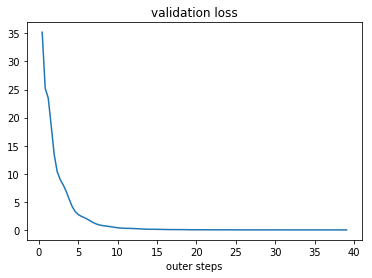

In [13]:
K = 100
eval_interval = 10
T = 50
mu = .1
beta = .01

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time, hg_norms = 0,  [], [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hgvesj(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)
    hg_norms.append(torch.norm(hparams[0].grad))

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
plt.plot(running_time, val_losses)
#plt.savefig('plots/val_loss2.png', bbox_inches='tight')
#plt.close()
plt.show()

norm_zoj50 = hg_norms
val_zoj50 = val_losses
run_zoj50 = running_time



In [18]:
run_zoj5 = [t / 4 for t in run_zoj10]
run_zoj10 = [t / 4 for t in run_zoj10]
run_zoj20 = [t / 4 for t in run_zoj20]
run_zoj50 = [t / 4 for t in run_zoj50]

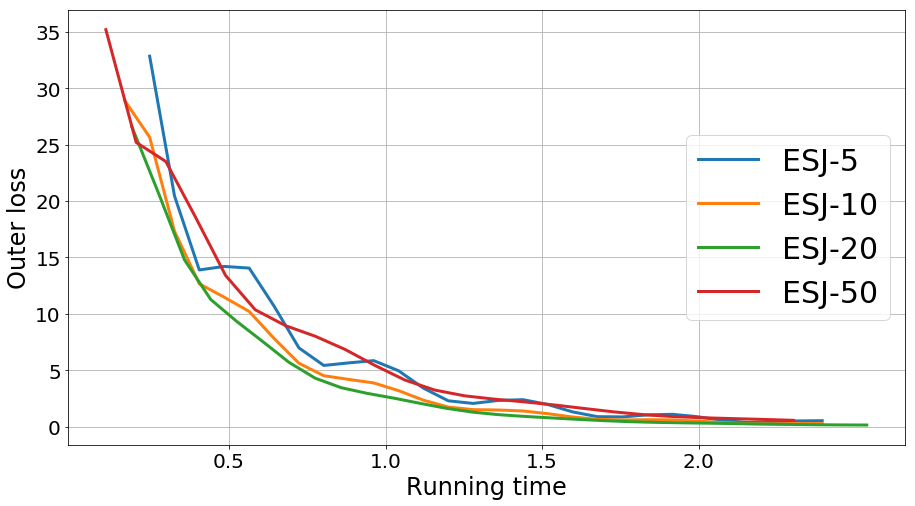

In [22]:
s1 = 24
s2 = 30

lw = 3
iters = list(range(K))
plt.plot(run_zoj5[2:s2], val_zoj5[2:s2], '-', label='ESJ-5', linewidth=lw)
plt.plot(run_zoj10[1:s2], val_zoj10[1:s2], '-', label='ESJ-10', linewidth=lw)
plt.plot(run_zoj20[1:s2], val_zoj20[1:s2], '-', label='ESJ-20', linewidth=lw)
plt.plot(run_zoj50[:s1], val_zoj50[:s1], '-', label='ESJ-50', linewidth=lw)
plt.xlabel('Running time', fontsize=24)
plt.ylabel('Outer loss', fontsize=24)
plt.xticks([0.5, 1, 1.5, 2], fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='center right', fontsize=30)
plt.grid()
plt.gcf().set_size_inches(15, 8)
plt.show()